In [ ]:
import pandas as pd
import polars as pl
from pathlib import Path
from download_and_preprocessing import Preprocessor
from pprint import pprint
import numpy as np
from loguru import logger
from time import time
from gensim.models import ensemblelda
from gensim.models import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import os

paths = {
        "metadata": Path(r"data\export_datamart.csv"),
        "all_speeches": Path(r"data\all_ECB_speeches.csv"),
        "html_dir": Path(r"data\speeches"),
        "parsed_file": Path(r"data\speeches\parsed.jsonl"),
        "preprocessed_dir": Path(r"data\preprocessed_en"),
    }

preprocessed_data, dictionary, bow_corpus, tfidf_corpus = Preprocessor().load_df_dict_corpus(paths["preprocessed_dir"])

In [187]:
# Finding out the optimal number of topics
coherence_list = []
lda_tfidf_k = {}
num_topics = np.arange(1,326,25)

for k in num_topics:
    np.random.seed(42)
    logger.info(f"Training LDA model with {k} topics")
    start = time()
    temp_lda = LdaMulticore(tfidf_corpus, num_topics=k, id2word=dictionary, passes=10, workers = os.cpu_count() - 2)
    lda_tfidf_k[k] = {}
    lda_tfidf_k[k]['model'] = temp_lda
    temp_coherence_model = CoherenceModel(model = temp_lda, corpus = tfidf_corpus, coherence = 'u_mass')
    lda_tfidf_k[k]['coherence_model'] = temp_coherence_model
    lda_tfidf_k[k]['coherence_score'] = temp_coherence_model.get_coherence()
    logger.info(f"Runtime for training LDA model with {k} topics: {time()-start:.2f} seconds")

2025-03-24T22:57:31.973235+0100 | INFO | 2689928410.<module>:8 | Training LDA model with 1 topics


2025-03-24T23:05:31.398139+0100 | INFO | 2689928410.<module>:16 | Runtime for training LDA model with 1 topics: 479.42 seconds
2025-03-24T23:05:31.402147+0100 | INFO | 2689928410.<module>:8 | Training LDA model with 26 topics
2025-03-24T23:18:57.219369+0100 | INFO | 2689928410.<module>:16 | Runtime for training LDA model with 26 topics: 805.82 seconds
2025-03-24T23:18:57.225380+0100 | INFO | 2689928410.<module>:8 | Training LDA model with 51 topics
2025-03-24T23:31:52.449471+0100 | INFO | 2689928410.<module>:16 | Runtime for training LDA model with 51 topics: 775.22 seconds
2025-03-24T23:31:52.453607+0100 | INFO | 2689928410.<module>:8 | Training LDA model with 76 topics
2025-03-24T23:44:45.785754+0100 | INFO | 2689928410.<module>:16 | Runtime for training LDA model with 76 topics: 773.33 seconds
2025-03-24T23:44:45.790126+0100 | INFO | 2689928410.<module>:8 | Training LDA model with 101 topics
2025-03-24T23:57:21.637191+0100 | INFO | 2689928410.<module>:16 | Runtime for training LDA m

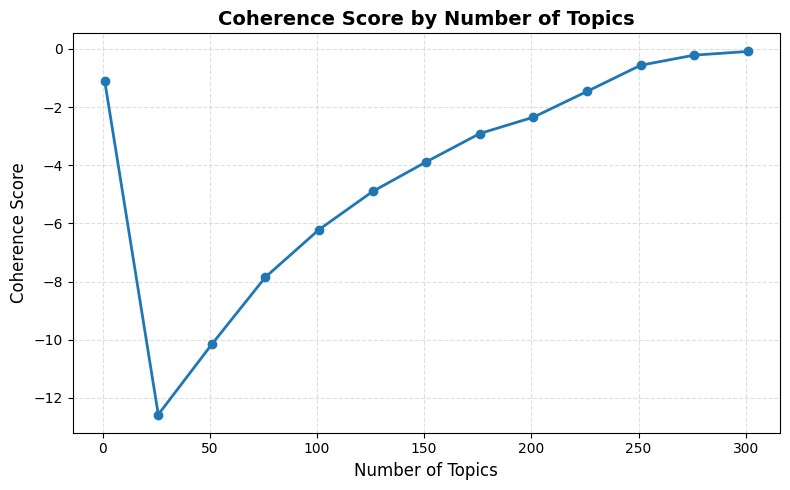

In [189]:
# lda_tfidf_k
from matplotlib import pyplot as plt
x = list(lda_tfidf_k.keys())
y = [v['coherence_score'] for v in lda_tfidf_k.values()]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, y, marker='o', linewidth=2)

# Styling
plt.title("Coherence Score by Number of Topics", fontsize=14, weight='bold')
plt.xlabel("Number of Topics", fontsize=12)
plt.ylabel("Coherence Score", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, which='major', linestyle='--', alpha=0.4)
plt.tight_layout()

plt.show()

In [193]:
pprint(lda_tfidf_k[num_topics[np.argmin(y)]])
pprint(lda_tfidf_k[num_topics[np.argmin(y)]]["model"].show_topics())

{'coherence_model': <gensim.models.coherencemodel.CoherenceModel object at 0x000001C3601EFCD0>,
 'coherence_score': -12.574210310349077,
 'model': <gensim.models.ldamulticore.LdaMulticore object at 0x000001C395B8D2D0>}
[(2,
  '0.001*"crt" + 0.000*"jct" + 0.000*"ipn" + 0.000*"enron" + 0.000*"weser" + '
  '0.000*"villa" + 0.000*"cernobbio" + 0.000*"kurier" + 0.000*"cyclic" + '
  '0.000*"este"'),
 (10,
  '0.001*"anacredit" + 0.000*"eacee" + 0.000*"rmb" + 0.000*"escudo" + '
  '0.000*"fcis" + 0.000*"centralbank" + 0.000*"ecbsolvency" + '
  '0.000*"certificate" + 0.000*"verhofstadt" + 0.000*"fci"'),
 (4,
  '0.001*"faz" + 0.000*"serbia" + 0.000*"brown" + 0.000*"nb" + 0.000*"geoff" + '
  '0.000*"dimitris" + 0.000*"georgarakos" + 0.000*"kenny" + 0.000*"belgrade" + '
  '0.000*"climate"'),
 (20,
  '0.000*"efb" + 0.000*"caribbean" + 0.000*"karamanlis" + 0.000*"konstantinos" '
  '+ 0.000*"sepa" + 0.000*"payment" + 0.000*"integration" + 0.000*"sehr" + '
  '0.000*"fiscal" + 0.000*"inflation"'),
 (15,

In [200]:
from gensim.models import EnsembleLda
from tqdm import tqdm

# Define range of number of topics
e_num_topics = np.arange(1, 51, 10)

# Store results
e_coherence_list = []
e_lda_tfidf_k = {}

best_score = float('-inf')
best_model = None
best_k = None

# Loop over different topic numbers
for k in tqdm(e_num_topics, desc="Training Ensemble LDA Models"):
    np.random.seed(42)

    logger.info(f"Training EnsembleLda with {k} models")
    start = time()

    # Train Ensemble LDA model
    temp_lda = EnsembleLda(
        topic_model_class="ldamulticore",
        corpus=tfidf_corpus,
        num_topics=26,
        num_models = k,
        id2word=dictionary,
        passes=10,
        workers=os.cpu_count() - 2
    )

    # Coherence Model
    temp_coherence_model = CoherenceModel(
        model=temp_lda,
        corpus=tfidf_corpus,  
        coherence='u_mass'   
    )

    score = temp_coherence_model.get_coherence()
    e_coherence_list.append((k, score))

    # Save all model info
    e_lda_tfidf_k[k] = {
        'model': temp_lda,
        'coherence_model': temp_coherence_model,
        'coherence_score': score
    }

    logger.info(f"Coherence score for {k} topics: {score:.4f}")
    logger.info(f"Runtime: {time() - start:.2f} seconds")

    # Check for best model
    if score > best_score:
        best_score = score
        best_model = temp_lda
        best_k = k

Training Ensemble LDA Models:   0%|          | 0/5 [00:00<?, ?it/s]

2025-03-25T14:13:04.242023+0100 | INFO | 1201566139.<module>:19 | Training EnsembleLda with 1 models
2025-03-25T14:25:57.625784+0100 | INFO | 1201566139.<module>:50 | Coherence score for 1 topics: -18.3044
2025-03-25T14:25:57.629383+0100 | INFO | 1201566139.<module>:51 | Runtime: 773.39 seconds


Training Ensemble LDA Models:  20%|██        | 1/5 [12:53<51:33, 773.39s/it]

2025-03-25T14:25:57.635450+0100 | INFO | 1201566139.<module>:19 | Training EnsembleLda with 11 models
2025-03-25T16:37:35.588309+0100 | INFO | 1201566139.<module>:50 | Coherence score for 11 topics: -5.4927
2025-03-25T16:37:35.592315+0100 | INFO | 1201566139.<module>:51 | Runtime: 7897.95 seconds


Training Ensemble LDA Models:  40%|████      | 2/5 [2:24:31<4:08:12, 4964.32s/it]

2025-03-25T16:37:35.599843+0100 | INFO | 1201566139.<module>:19 | Training EnsembleLda with 21 models


c:\Users\povhi\anaconda3\envs\dsa\Lib\site-packages\gensim\models\ensemblelda.py:515: RuntimeWarning: overflow encountered in scalar multiply
  percent = round(100 * avg_mask_size / ttda1.shape[0] / ttda1.shape[1], 1)


2025-03-25T20:22:56.702700+0100 | INFO | 1201566139.<module>:50 | Coherence score for 21 topics: -4.4030
2025-03-25T20:22:56.705703+0100 | INFO | 1201566139.<module>:51 | Runtime: 13521.10 seconds


Training Ensemble LDA Models:  60%|██████    | 3/5 [6:09:52<4:55:43, 8871.53s/it]

2025-03-25T20:22:56.710707+0100 | INFO | 1201566139.<module>:19 | Training EnsembleLda with 31 models
2025-03-26T01:48:11.166665+0100 | INFO | 1201566139.<module>:50 | Coherence score for 31 topics: -2.8554
2025-03-26T01:48:11.170811+0100 | INFO | 1201566139.<module>:51 | Runtime: 19514.46 seconds


Training Ensemble LDA Models:  80%|████████  | 4/5 [11:35:06<3:37:53, 13073.24s/it]

2025-03-26T01:48:11.175807+0100 | INFO | 1201566139.<module>:19 | Training EnsembleLda with 41 models
2025-03-26T08:57:17.835011+0100 | INFO | 1201566139.<module>:50 | Coherence score for 41 topics: -3.9464
2025-03-26T08:57:17.838039+0100 | INFO | 1201566139.<module>:51 | Runtime: 25746.66 seconds


Training Ensemble LDA Models: 100%|██████████| 5/5 [18:44:13<00:00, 13490.72s/it]  


In [ ]:
[x[0] for x in e_coherence_list]
[x[1] for x in e_coherence_list]

[(1, -18.304437559865594),
 (11, -5.492688265233937),
 (21, -4.403021160174815),
 (31, -2.855352404377162),
 (41, -3.94640560233227)]

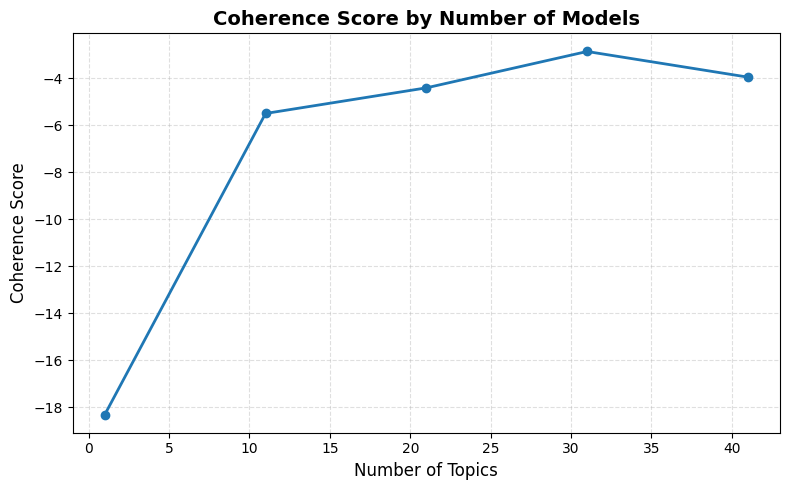

In [203]:
# lda_tfidf_k
from matplotlib import pyplot as plt
x = list(lda_tfidf_k.keys())
y = [v['coherence_score'] for v in lda_tfidf_k.values()]

# Plot
plt.figure(figsize=(8, 5))
plt.plot([x[0] for x in e_coherence_list], [x[1] for x in e_coherence_list], marker='o', linewidth=2)

# Styling
plt.title("Coherence Score by Number of Models", fontsize=14, weight='bold')
plt.xlabel("Number of Topics", fontsize=12)
plt.ylabel("Coherence Score", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, which='major', linestyle='--', alpha=0.4)
plt.tight_layout()

plt.show()